In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [36]:
file_path = "UKElectricity.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)


In [37]:
display(df.head())
df.isnull().sum()


,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,
2023-01-01 00:00:00,48.90,605.00,1,0,1,2023,1,1,52,16.95,1.033832,21.294832,27239
2023-01-01 00:30:00,49.13,759.15,2,0,1,2023,1,1,52,16.95,1.033832,21.294832,27814
2023-01-01 01:00:00,45.62,659.35,3,1,1,2023,1,1,52,16.95,1.033832,21.294832,27453
2023-01-01 01:30:00,47.05,612.65,4,1,1,2023,1,1,52,16.95,1.033832,21.294832,26312
2023-01-01 02:00:00,46.83,699.15,5,2,1,2023,1,1,52,16.95,1.033832,21.294832,25289


,0
Price,0
Volume,0
Settlement Period,0
hour,0
quarter,0
year,0
dayofyear,0
dayofmonth,0
weekofyear,0
SAP,0


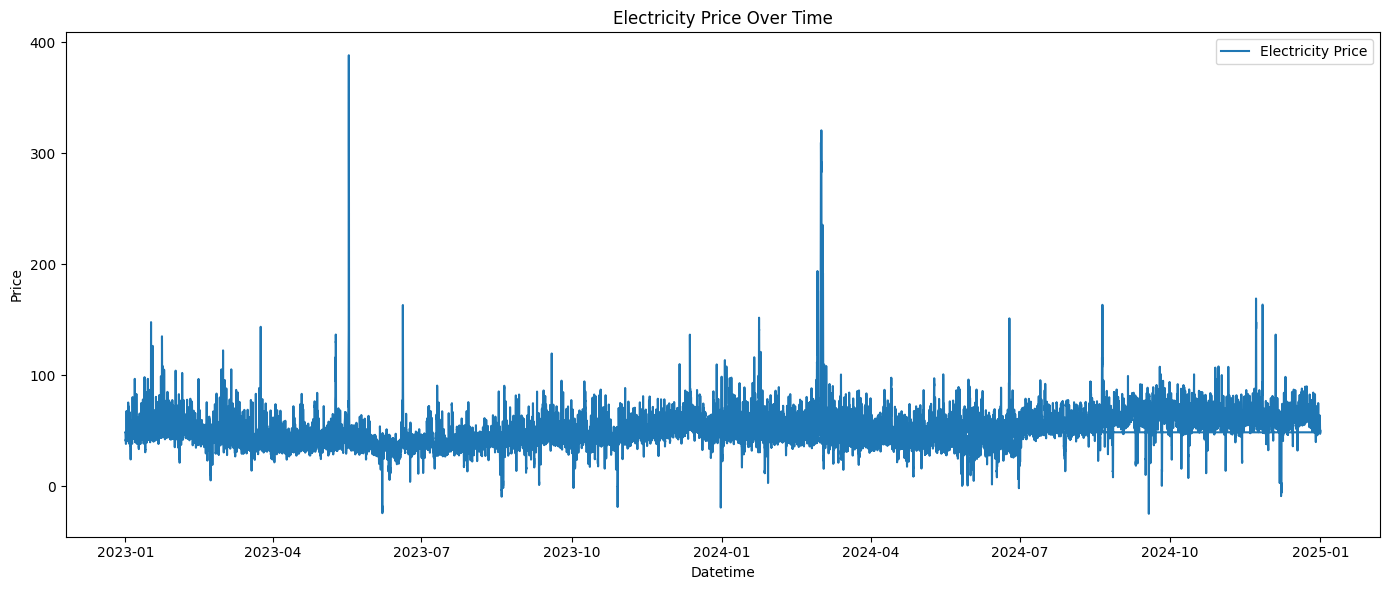

In [38]:
plt.figure(figsize=(14, 6))
plt.plot(df["Price"], label="Electricity Price")
plt.title("Electricity Price Over Time")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Price"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Apply differencing if not stationary
if result[1] > 0.05:
    df["Price_diff"] = df["Price"].diff()
    df.dropna(inplace=True)
    target_series = df["Price_diff"]
    differenced = True
else:
    target_series = df["Price"]
    differenced = False



ADF Statistic: -12.33835164052419
p-value: 6.199190306183758e-23


In [40]:
split_index = int(len(target_series) * 0.8)
train = target_series[:split_index]
test = target_series[split_index:]


In [41]:
model = ARIMA(train, order=(5, 0, 2))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                34712
Model:                 ARIMA(5, 0, 2)   Log Likelihood             -102404.442
Date:                Fri, 23 May 2025   AIC                         204826.884
Time:                        05:37:34   BIC                         204902.978
Sample:                             0   HQIC                        204851.131
                              - 34712                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.7858      0.517     98.216      0.000      49.772      51.799
ar.L1          0.3873      0.005     77.139      0.000       0.377       0.397
ar.L2         -0.1785      0.005    -33.446      0.0

In [42]:
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
if differenced:
    # Reconstruct original series from the last training value
    last_value = df["Price"].iloc[split_index - 1]
    forecast_cumsum = forecast.cumsum()
    forecast_values = last_value + forecast_cumsum
    actual_values = df["Price"].iloc[split_index:]
else:
    forecast_values = forecast
    actual_values = test


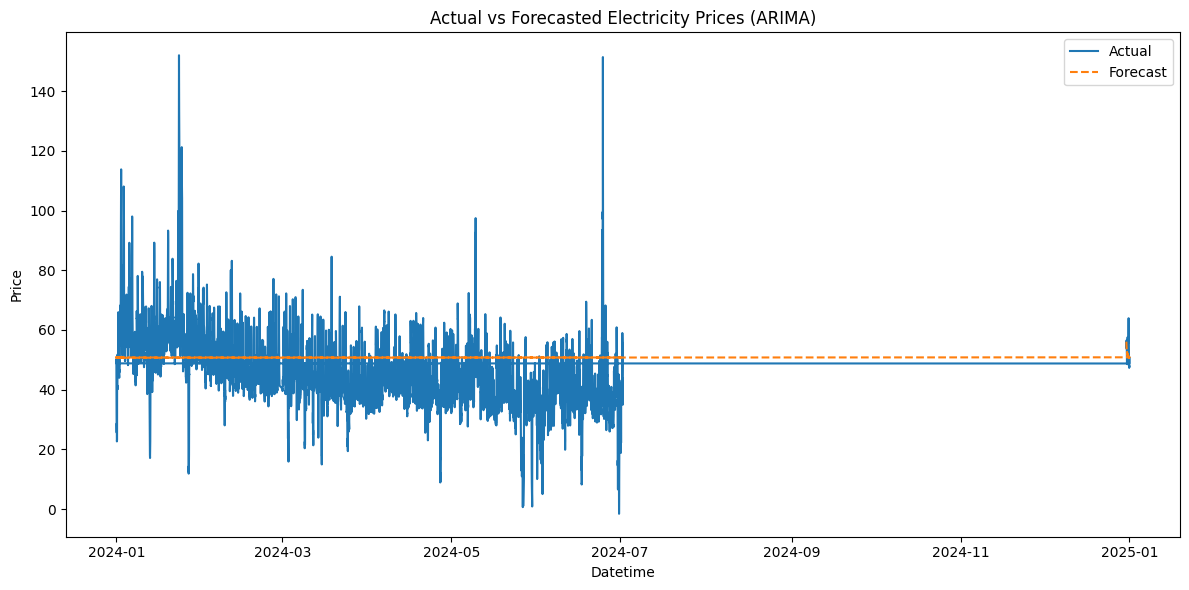

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual")
plt.plot(forecast_values, label="Forecast", linestyle="--")
plt.title("Actual vs Forecasted Electricity Prices (ARIMA)")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()



In [45]:
mse = mean_squared_error(actual_values, forecast_values)
mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mse)

# Avoid division by zero in MAPE
non_zero_actuals = actual_values[actual_values != 0]
non_zero_forecast = forecast_values[actual_values != 0]
mape = np.mean(np.abs((non_zero_actuals - non_zero_forecast) / non_zero_actuals)) * 100
r2 = r2_score(actual_values, forecast_values)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")



MSE: 186.1077
MAE: 10.6685
RMSE: 13.6421
MAPE: 31.66%
R²: -0.1433
